<div style="color:white;background-color:#00A67E;padding:3%;border-radius:150px 150px;font-size:2em;text-align:center">
    <font color="White" size=+4 face="Arial Black">Twitter Hate Speech</font><br><font color="White" size=+2 face="Lucida Calligraphy">(Sentiments, Topics, Modeling)</font>
</div>

# Importing Packages

In [1]:
# General packages
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Text Processing and preprocessing
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag

# Sentiment Analysis Packages
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Topic Modeling
from gensim import corpora, models

# Options
pd.options.display.max_columns = None
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Loading Dataset

In [2]:
df = pd.read_csv(r'/kaggle/input/twitter-hate-speech/train_E6oV3lV.csv', low_memory = False)
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Data Understanding

In [3]:
# Statistical Distribution of the the Numerical variables in the tweets dataset
print(df.shape)
df.describe()

(31962, 3)


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [4]:
# A summary of the overall dataset
def summary(df):
    summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    summary['missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    return summary

summary(df)

,index,dtypes,missing,Uniques
0,id,int64,0,31962
1,label,int64,0,2
2,tweet,object,0,29530


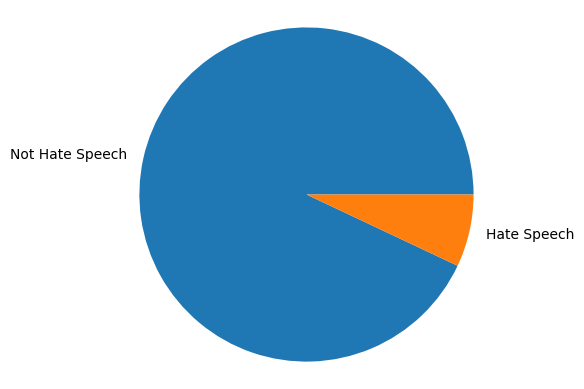

In [5]:
plt.pie(df.label.value_counts(), labels = ['Not Hate Speech', 'Hate Speech'])
plt.axis('equal')
plt.show()

# Data Preprocessing

### Sentence Tokenizing

In [6]:
nltk.download('punkt')

sent_tokenized = []

for text in df['tweet'].values:
    tokens = nltk.sent_tokenize(text)
    sent_tokenized.append(tokens)

df['Sentence Tokenized'] = sent_tokenized
df.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,label,tweet,Sentence Tokenized
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...
2,3,0,bihday your majesty,[ bihday your majesty]
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation]


### Word Tokenizing

In [7]:
# For topic modeling we start form the body of tweets to perform word tokenizing.
all_docs = df['tweet'].values

exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())

df['Word Tokenized'] = tokenized
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]"


### Removing Punctuations

In [8]:
def remove_punctuation(tokens):
    punctuations = string.punctuation
    tokens = [token.translate(str.maketrans('', '', punctuations)) for token in tokens]
    tokens = [token for token in tokens if len(token) > 1]
    return tokens

df['Punctuation Removed'] = df['Word Tokenized'].apply(remove_punctuation)
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ..."
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


### Removing StopWords and Other Unnecessaries

In [9]:
sw = set(stopwords.words('english'))
sw.add('rt')
sw.add('...')

sw_removed = []
for j, sent in enumerate(df['Word Tokenized']):
    sw_removed.append([i for i in sent
                      if i not in sw
                      and len(i)>2
                      and (not i.startswith("http"))])

df['Stopword Removed'] = sw_removed
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]"
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]"


### Part of Speech Tagging

In [10]:
pos_tags_list = []
for tokens in df['Word Tokenized']:
    pos_tags = nltk.pos_tag(tokens)
    pos_tags_list.append(pos_tags)
df['pos_tags'] = pos_tags_list
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (..."
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (..."


### Word Stemming

In [11]:
stemmer = PorterStemmer()
def stemming(words):
    return [stemmer.stem(word) for word in words]

df['Word Stemmed'] = df['Stopword Removed'].apply(stemming)
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]"
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]"


### Lemmatization

In [12]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if not token.is_punct and not token.is_space and token.is_alpha:
                if token.pos_ in allowed_postags:
                    new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

df['Lemmatized Text'] = lemmatization(df['tweet'])

df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation


### Word Tokenizing The Lemmatized Column

In [13]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_and_tokenize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ", "ADV"]]
    return tokens

df['Tokenized Lem'] = df['Lemmatized Text'].apply(lemmatize_and_tokenize)
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]"
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]"
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[]
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]"
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]"


# Feature Engineering
## Adding Sentiments as Features

In [14]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

scores = []
for sentence_list in df['tweet'].apply(nltk.sent_tokenize):
    sentence_scores = []
    for sentence in sentence_list:
        sentence_score = sid.polarity_scores(sentence)
        sentence_scores.append(sentence_score)
    avg_score = {k: sum(d[k] for d in sentence_scores) / len(sentence_scores) for k in sentence_scores[0]}
    scores.append(avg_score)

sentiment_df = pd.DataFrame(scores)
df = pd.concat([df, sentiment_df], axis=1)

df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem,neg,neu,pos,compound
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]",0.201,0.799,0.000,-0.41480
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]",0.000,0.859,0.141,0.33525
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[],0.000,1.000,0.000,0.00000
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]",0.000,0.806,0.194,0.36245
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]",0.000,1.000,0.000,0.00000


**By reviewing the texts and the scores of VADER technique, it seems that the model did not scored the sentences correctly, we we incorporating other techniques aiming better results**

### Assigning Labels to Sentiments

In [15]:
#Labeling the sentiments based on the compound score
def label_sentiment(row):
    cutoff = .33
    if row['compound'] < -1 * cutoff:
        return "neg"
    elif row['compound'] > cutoff:
        return "pos"
    else:
        return "neu"
    
df["label_sent"] = df.apply(label_sentiment, axis=1)

# Sentiment of the whole Small dataset
total_sent_small = np.mean(df['compound'])
print("Sentiment of the whole small dataset: ", total_sent_small)
df.head()

Sentiment of the whole small dataset:  0.09458568033170342


,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem,neg,neu,pos,compound,label_sent
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]",0.201,0.799,0.000,-0.41480,neg
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]",0.000,0.859,0.141,0.33525,pos
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[],0.000,1.000,0.000,0.00000,neu
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]",0.000,0.806,0.194,0.36245,pos
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]",0.000,1.000,0.000,0.00000,neu


### Statistics of the Sentiments

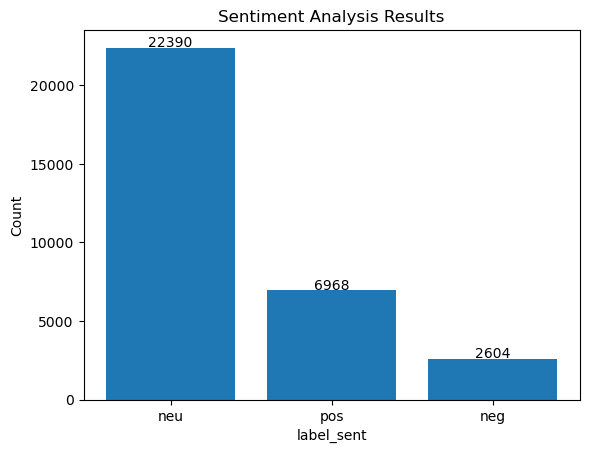

In [16]:
counts = df['label_sent'].value_counts()
plt.bar(counts.index, counts.values)

for i, count in enumerate(counts.values):
    plt.text(i, count+50, str(count), ha='center')

plt.xlabel('label_sent')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')

plt.show()

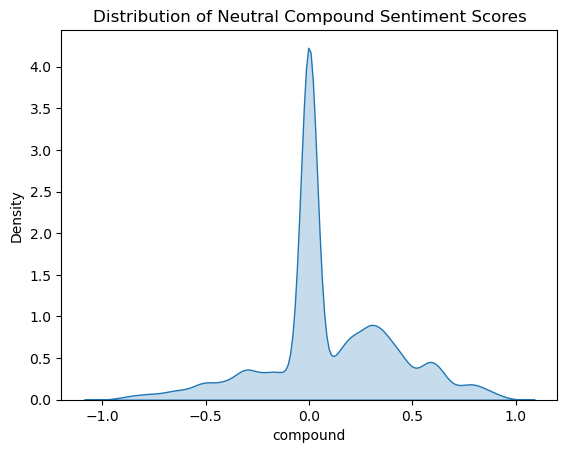

In [17]:
sns.kdeplot(data=df, x='compound', label='compound', fill=True)

plt.title("Distribution of Neutral Compound Sentiment Scores")
plt.show()

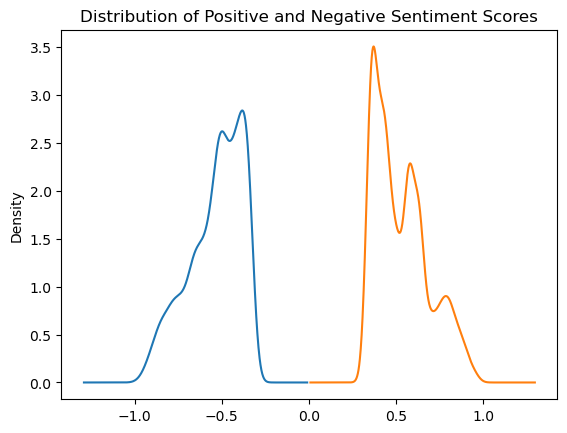

In [18]:
df[df.label_sent=="neg"]['compound'].plot.kde();
df[df.label_sent=="pos"]['compound'].plot.kde();
plt.title("Distribution of Positive and Negative Sentiment Scores")
plt.show()

# Data Cleansing Via Regex

In [19]:
# define regex patterns
url_pattern = r'http\S+'
user_pattern = r'@[A-Za-z0-9]+'
special_char_pattern = r'[^\w\s]'
number_pattern = r'\d+'

# define stopwords
stop_words = set(stopwords.words('english'))

# clean the text data using regex
df['regex'] = df['tweet'].apply(lambda x: re.sub(url_pattern, '', x)) # remove URLs
df['regex'] = df['regex'].apply(lambda x: re.sub(user_pattern, '', x)) # remove usernames
df['regex'] = df['regex'].apply(lambda x: re.sub(special_char_pattern, '', x)) # remove special characters
df['regex'] = df['regex'].apply(lambda x: re.sub(number_pattern, '', x)) # remove numbers
df['regex'] = df['regex'].apply(lambda x: x.lower()) # convert to lowercase
df['regex'] = df['regex'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words])) # remove stopwords

df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem,neg,neu,pos,compound,label_sent,regex
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]",0.201,0.799,0.000,-0.41480,neg,father dysfunctional selfish drags kids dysfun...
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]",0.000,0.859,0.141,0.33525,pos,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[],0.000,1.000,0.000,0.00000,neu,bihday majesty
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]",0.000,0.806,0.194,0.36245,pos,model love u take u time urð ðððð ððð
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]",0.000,1.000,0.000,0.00000,neu,factsguide society motivation


## Feature Extraction
### TF-IDF Model

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 2000)
tfidf_features = tfidf.fit_transform(df['tweet'])

df['tfidf_features'] = tfidf_features.toarray().tolist()

df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem,neg,neu,pos,compound,label_sent,regex,tfidf_features
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]",0.201,0.799,0.000,-0.41480,neg,father dysfunctional selfish drags kids dysfun...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]",0.000,0.859,0.141,0.33525,pos,thanks lyft credit cant use cause dont offer w...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[],0.000,1.000,0.000,0.00000,neu,bihday majesty,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]",0.000,0.806,0.194,0.36245,pos,model love u take u time urð ðððð ððð,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]",0.000,1.000,0.000,0.00000,neu,factsguide society motivation,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [21]:
df.columns

Index(['id', 'label', 'tweet', 'Sentence Tokenized', 'Word Tokenized',
       'Punctuation Removed', 'Stopword Removed', 'pos_tags', 'Word Stemmed',
       'Lemmatized Text', 'Tokenized Lem', 'neg', 'neu', 'pos', 'compound',
       'label_sent', 'regex', 'tfidf_features'],
      dtype='object')

In [22]:
df.to_csv('df.csv')

# Modeling

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Prepare the data
X = np.array(df['tfidf_features'].values.tolist())
y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
model = keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))  # 2 units for binary classification

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train and evaluate the model
model.fit(X_train[:, :, np.newaxis], keras.utils.to_categorical(y_train), batch_size=64, epochs=10, validation_split=0.1)

accuracy = model.evaluate(X_test[:, :, np.newaxis], keras.utils.to_categorical(y_test))[1]
print(f'Test Accuracy: {accuracy:.4f}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1998, 32)          128       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,370
Trainable params: 2,370
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
360/360 [==============================] - 12s 31ms/step - loss: 0.2817 - accuracy: 0.9300 - val_loss: 0.2500

### Model Tuning

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Train Word2Vec model
sentences = df['Tokenized Lem'].tolist()
embedding_dim = 100  # You can adjust the dimensionality of the word embeddings
w2v_model = Word2Vec(sentences, vector_size=embedding_dim, min_count=1)

# Prepare the data
X_tfidf = np.array(df['tfidf_features'].values.tolist())
X_sentiment = np.array(df[['neg', 'neu', 'pos', 'compound']])

# Get the word embeddings for 'Tokenized Lem'
X_lemmatized = np.array([
    [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    for tokens in sentences
])

# Pad the arrays
max_len = max(len(seq) for seq in X_lemmatized)
X_tfidf = pad_sequences(X_tfidf, maxlen=max_len, padding='post', dtype='float32')
X_sentiment = pad_sequences(X_sentiment, maxlen=max_len, padding='post', dtype='float32')
X_lemmatized = pad_sequences(X_lemmatized, maxlen=max_len, padding='post', dtype='float32')

# Reshape the arrays
X_tfidf = X_tfidf.reshape(X_tfidf.shape[0], X_tfidf.shape[1], 1)
X_sentiment = X_sentiment.reshape(X_sentiment.shape[0], X_sentiment.shape[1], 1)

# Concatenate the features
X = np.concatenate((X_tfidf, X_sentiment, X_lemmatized), axis=2)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
model = keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train and evaluate the model
model.fit(X_train, keras.utils.to_categorical(y_train), batch_size=64, epochs=10, validation_split=0.1)

accuracy = model.evaluate(X_test, keras.utils.to_categorical(y_test))[1]
print(f'Test Accuracy: {accuracy:.4f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 15, 32)            9824      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12,066
Trainable params: 12,066
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
360/360 [==============================] - 3s 5ms/step - loss: 0.2408 - accuracy: 0.9300 - val_loss: 0.21

### Naive Bayes, Support Vector Machines (SVM), and Random Forest

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare the data
X = df['Tokenized Lem'].apply(lambda x: ' '.join(x))
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
nb_pred = nb_clf.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f'Naive Bayes Accuracy: {nb_accuracy:.4f}')

# Support Vector Machines (SVM) classifier
svm_clf = SVC()
svm_clf.fit(X_train_tfidf, y_train)
svm_pred = svm_clf.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

# Random Forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_tfidf, y_train)
rf_pred = rf_clf.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')


Naive Bayes Accuracy: 0.9384
SVM Accuracy: 0.9492
Random Forest Accuracy: 0.9518


In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare the data
X_text = df['Tokenized Lem'].apply(lambda x: ' '.join(x))
X_sentiment = np.array(df[['neg', 'neu', 'pos', 'compound']])
X_tfidf = np.array(df['tfidf_features'].values.tolist())
y = np.array(df['label'])

# Split the data into training and testing sets
X_text_train, X_text_test, X_sentiment_train, X_sentiment_test, X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
    X_text, X_sentiment, X_tfidf, y, test_size=0.2, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer()
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_text_train_tfidf, y_train)
nb_pred = nb_clf.predict(X_text_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f'Naive Bayes Accuracy: {nb_accuracy:.4f}')

# Support Vector Machines (SVM) classifier
svm_clf = SVC()
svm_clf.fit(X_text_train_tfidf, y_train)
svm_pred = svm_clf.predict(X_text_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

# Random Forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_text_train_tfidf, y_train)
rf_pred = rf_clf.predict(X_text_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')


Naive Bayes Accuracy: 0.9384
SVM Accuracy: 0.9492
Random Forest Accuracy: 0.9520


In [29]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint

# Prepare the data
X_text = df['Tokenized Lem'].apply(lambda x: ' '.join(x))
X_sentiment = np.array(df[['neg', 'neu', 'pos', 'compound']])
X_tfidf = np.array(df['tfidf_features'].values.tolist())
y = np.array(df['label'])

# Split the data into training and testing sets
X_text_train, X_text_test, X_sentiment_train, X_sentiment_test, X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
    X_text, X_sentiment, X_tfidf, y, test_size=0.2, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer()
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Define the parameter distributions for randomized search
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
}

# Create the Random Forest classifier
rf_clf = RandomForestClassifier()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=10, cv=2)
random_search.fit(X_text_train_tfidf, y_train)

# Get the best hyperparameters and evaluate the model
best_params = random_search.best_params_
best_rf_clf = RandomForestClassifier(**best_params)
best_rf_clf.fit(X_text_train_tfidf, y_train)
best_rf_pred = best_rf_clf.predict(X_text_test_tfidf)
best_rf_accuracy = accuracy_score(y_test, best_rf_pred)
print(f'Best Random Forest Accuracy: {best_rf_accuracy:.4f}')
print('Best Hyperparameters:', best_params)

Best Random Forest Accuracy: 0.9470
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 504}
